In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import cyipopt

from functools import partial
from typing import *
from dataclasses import dataclass, field
from jaxlie import SE3, SO3
import jax_dataclasses as jdc

from sdf_world.sdf_world import *
from sdf_world.robot_model import *
from sdf_world.robots import *

import time

In [2]:
world = SDFWorld()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [3]:
gen3 = get_predefined_robot(world.vis, "gen3+hand_e")

In [192]:
fk_full = gen3.arm.model.get_serial_links_fk_fn(gen3.tool_pose_offset)

In [4]:
fk_ee = gen3.arm.model.get_fk_ee_fn(gen3.tool_pose_offset)

In [5]:
def get_random_config(size=1):
    lb, ub = gen3.arm.model.lb, gen3.arm.model.ub
    if size==1:
        return np.random.uniform(lb, ub)
    else:
        return np.random.uniform(lb, ub, size=(size,7))

In [8]:
frame = Frame(world.vis, "frame")

In [10]:
q = get_random_config()
gen3.set_joint_angles(q)
frame.set_pose(SE3(fk(q)))

In [33]:
jac = jax.jacfwd(fk)

In [197]:
def geom_jac(q):
    fks = fk_full(q)
    qtn, p_ee = fks[-1][:4], fks[-1][-3:]
    w, xyz = qtn[0], qtn[1:]
    geom_jac = []
    for posevec in fks[gen3.arm.model.movable_joints]:
        p_frame = posevec[-3:]
        rot_axis = SE3(posevec).as_matrix()[:3, 2]
        lin_vel = jnp.cross(rot_axis, p_ee - p_frame)
        geom_jac.append(jnp.hstack([lin_vel, rot_axis]))
    geom_jac = jnp.array(geom_jac).T  #geom_jacobian
    return geom_jac

In [51]:
pos_jac = jac(q)[-3:,:]
manip = jnp.sqrt(jnp.linalg.det(pos_jac@pos_jac.T))

In [21]:
limited_joint_indices = [i 
            for i, joint in enumerate(gen3.arm.model.joints.values())
            if joint.joint_type in ["revolute", "prismatic"]]
limited_joint_indices = np.array(limited_joint_indices)

In [200]:
lb = gen3.arm.model.lb[limited_joint_indices]
ub = gen3.arm.model.ub[limited_joint_indices]

def joint_limit_potential(q, scale=2.):
        q_limited_joint = q[limited_joint_indices]
        value = jnp.sum( 0.1*(ub - lb)**2 / (4 * (q_limited_joint - lb) * (ub - q_limited_joint) ))
        return jnp.exp(-value* scale) 

def get_manip_limit_penalized(q):
    #pos_jac = jac(q)[-3:,:]
    j = geom_jac(q)
    manip = jnp.sqrt(jnp.linalg.det(j@j.T))
    limit_penalty = joint_limit_potential(q)
    return manip * limit_penalty


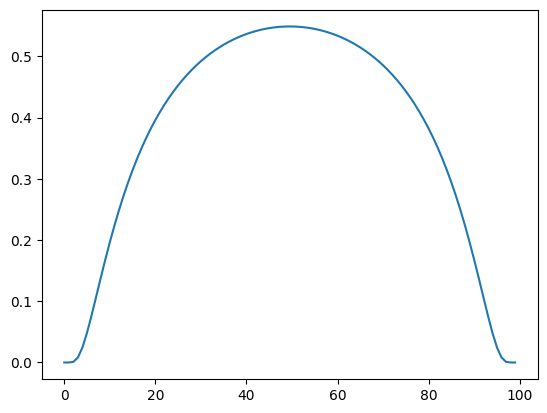

In [201]:
qs = np.linspace(gen3.arm.model.lb+0.01, gen3.arm.model.ub-0.01, 100)
plt.plot([joint_limit_potential(q, 2.) for q in qs])

In [202]:
ws_r = 1.
ws_center = jnp.array([0,0,0.5])
xyz_res = 41
xx = jnp.linspace(-1, 1, xyz_res, endpoint=True)
yy = jnp.linspace(-1, 1, xyz_res, endpoint=True)
zz = jnp.linspace(-0.5, 1.5, xyz_res, endpoint=True)
zz = jnp.linspace(-0.5, 1.5, xyz_res, endpoint=True)
X, Y, Z = jnp.meshgrid(xx,yy,zz)
xyz_grids = jnp.vstack([X.flatten(), Y.flatten(), Z.flatten()]).T
in_ws_sphere = jnp.linalg.norm(xyz_grids - ws_center, axis=-1) < ws_r
xyz_grids = xyz_grids[in_ws_sphere]
qtn_grids = super_fibonacci_spiral(1000)

In [203]:
def rot_distance(qtn1, qtn2):
    rot_diff = SO3(qtn1).inverse() @ SO3(qtn2)
    angle = jnp.linalg.norm(rot_diff.log())
    return angle
def get_rot_grid_idx(qtn):
    errors = jax.vmap(rot_distance, in_axes=(None,0))(qtn, qtn_grids)
    return errors.argmin()
def get_xyz_grid_idx(xyz):
    errors = jnp.linalg.norm(xyz_grids - xyz, axis=-1)
    return errors.argmin()

def get_sample(q):
    ee_pose = fk(q)
    xyz_idx = get_xyz_grid_idx(ee_pose[-3:])
    qtn_idx = get_rot_grid_idx(ee_pose[:4])
    manip = get_manip_limit_penalized(q)
    return manip, qtn_idx, xyz_idx
get_samples = jax.jit(jax.vmap(get_sample))

In [ ]:
%load_ext cython
import Cython

In [ ]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange

#@cython.boundscheck(False)
#@cython.wraparound(False)
def insert_values(
    int[:, ::1] idxs, 
    np.float32_t[::1] manips, 
    np.float32_t[:,::1] manip_map, 
):
    cdef int updated
    cdef Py_ssize_t n = idxs.shape[0]
    cdef Py_ssize_t x, y, i
    cdef np.float32_t[:,:] map_view = manip_map
    cdef int[:,:] idxs_view = idxs
    cdef np.float32_t[:] manips_view = manips
    
    updated = 0
    for i in prange(n, nogil=True):    
        x = idxs_view[i, 0]
        y = idxs_view[i, 1]
        
        if map_view[x, y] < manips_view[i]:
            if map_view[x, y] == 0.: 
               updated += 1
            map_view[x, y] = manips_view[i]
    print(updated)

In [206]:
map_shape = len(qtn_grids), len(xyz_grids)
manip_map = np.zeros(map_shape, dtype=np.float32)
num_batch = 1000000

In [212]:
from IPython.display import clear_output
#loop
for epoch in range(1000):
    qs = get_random_config(num_batch)
    manips, qtn_idxs, xyz_idxs = get_samples(qs)
    idxs = jnp.vstack([qtn_idxs, xyz_idxs]).T
    clear_output(wait=True)
    print(f"i:{epoch}")
    insert_values(np.array(idxs), np.array(manips), manip_map)

i:999
208


In [222]:
#visualize
ws_r = 1.
ws_center = jnp.array([0,0,0.5])
# def get_manip_value_pred(wxyzxyz):
#     xyz, rot = wxyzxyz[-3:], wxyzxyz[3:4]
#     is_out_of_bound = jnp.linalg.norm(xyz - ws_center) > ws_r
#     return jax.lax.cond(
#         is_out_of_bound, lambda x:jnp.array([0.]), 
#         lambda x: manip_net.apply(params, x), posevec)

def get_manip_value_true(wxyzxyz):
    xyz, qtn = wxyzxyz[-3:], wxyzxyz[:4]
    is_out_of_bound = jnp.linalg.norm(xyz - ws_center) > ws_r
    if is_out_of_bound: return 0.
    xyz_idx = get_xyz_grid_idx(xyz)
    qtn_idx = get_rot_grid_idx(qtn)
    return manip_map[qtn_idx, xyz_idx]

In [232]:
qtn = np.random.normal(size=4)
qtn = qtn/np.linalg.norm(qtn)
rot = SO3(qtn)
z = 0.1

In [233]:
xx = np.linspace(-1, 1, 40)
yy = np.linspace(-1, 1, 40)
X, Y = np.meshgrid(xx, yy, indexing="ij")
xyz_samples = np.vstack([X.flatten(), Y.flatten(), np.full(40*40, z)]).T
qtn_samples = np.tile(qtn, len(xyz_samples)).reshape(-1, 4)
samples = jnp.hstack([qtn_samples, xyz_samples])
manips = [get_manip_value_true(sample) for sample in samples]

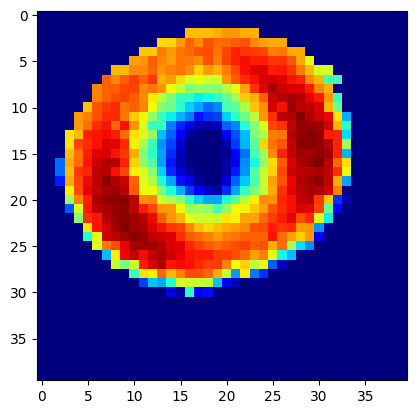

In [234]:
import matplotlib.pyplot as plt
plt.imshow(np.array(manips).reshape(40,-1), cmap="jet")

In [235]:
np.savez_compressed(
    "manip_data_gen3.npz", 
    manip_map=manip_map,
    qtn_grids=qtn_grids,
    xyz_grids=xyz_grids
)

In [ ]:
qtn = np.random.normal(size=4)
qtn = qtn/np.linalg.norm(qtn)
rot = SO3(qtn)
z = 0.1

In [236]:
from flax import linen as nn
import optax
from flax.training.train_state import TrainState
import orbax
from flax.training import orbax_utils

In [237]:
manip_data = np.load("manip_data_gen3.npz")
manip_map = manip_data["manip_map"]
qtn_grids = manip_data["qtn_grids"]
xyz_grids = manip_data["xyz_grids"]

In [238]:
manip_map = manip_map / manip_map.max() #scale to 0-1

In [249]:
class ManipNet(nn.Module):
    hidden_dim: int
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return nn.softplus(x)

In [250]:
manip_net = ManipNet(64)
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
x = jax.random.normal(key1, (7,)) #wxyzxyz
#x = jax.random.normal(key1, (7,)) #posevec
params = manip_net.init(key2, x)
tx = optax.adam(learning_rate=0.001)
state = TrainState.create(
    apply_fn=manip_net.apply,
    params=params,
    tx=tx
)

In [251]:
def loss_fn(state:TrainState, params, inputs, labels):
    preds = state.apply_fn(params, inputs).flatten()
    return optax.l2_loss(preds, labels).mean()

@jax.jit
def update(state:TrainState, inputs, labels):
    losses, grads = jax.value_and_grad(loss_fn, argnums=1)(state, state.params, inputs, labels)
    state = state.apply_gradients(grads=grads)
    return state, losses

In [253]:
from IPython.display import clear_output
to_rotvec = lambda x: SO3(x).log()

num_batch = 128
epochs = 10000
data_len = np.prod(manip_map.shape)
for i in range(epochs):
    #generate sample batch:
    rot_idxs = np.random.randint(len(qtn_grids), size=num_batch)
    xyz_idxs = np.random.randint(len(xyz_grids), size=num_batch)
    #rotvecs = jax.vmap(to_rotvec)()
    inputs = jnp.hstack([qtn_grids[rot_idxs], xyz_grids[xyz_idxs]])
    labels = jnp.asarray(manip_map[rot_idxs, xyz_idxs])
    state, loss = update(state, inputs, labels)
    if i%100 == 0:
        clear_output(True)
        print(f"epoch{i}  loss: {loss.item()}")

epoch9900  loss: 0.0014764433726668358


In [254]:
trained_params = state.params

In [256]:
#save
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
ckpt = {
    "params": trained_params
}
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('model/manip_net_gen3', ckpt, save_args=save_args)

In [257]:
#load
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
ckpt = orbax_checkpointer.restore('model/manip_net_gen3')
params = ckpt["params"]

#visualize
ws_r = 1.
ws_center = jnp.array([0,0,0.5])
def get_manip_value(wxyzxyz):
    xyz, qtn = wxyzxyz[-3:], wxyzxyz[:4]
    is_out_of_bound = jnp.linalg.norm(xyz - ws_center) > ws_r
    return jax.lax.cond(
        is_out_of_bound, lambda x:jnp.array([0.]), 
        lambda x: manip_net.apply(params, x), wxyzxyz)

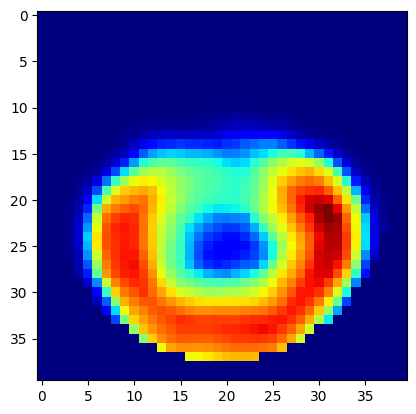

In [270]:
import matplotlib.pyplot as plt

qtn = np.random.normal(size=4)
qtn = qtn/np.linalg.norm(qtn)
rot = SO3(qtn)
z = 0.1

xx = np.linspace(-1, 1, 40)
yy = np.linspace(-1, 1, 40)
X, Y = np.meshgrid(xx, yy, indexing="ij")
xyz_samples = np.vstack([X.flatten(), Y.flatten(), np.full(40*40, z)]).T
qtn_samples = np.tile(qtn, len(xyz_samples)).reshape(-1, 4)

samples = jnp.hstack([qtn_samples, xyz_samples])
manips = jax.vmap(get_manip_value)(samples).flatten()
manips_xy = manips.reshape(40, -1)

plt.imshow(manips_xy, cmap="jet")